In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from tqdm import tqdm
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.distributions_pt import GMM #random_tilted_gaussian, Gaussian, GMM, RoughWell
from utils.notebook_utils_pt import get_hmc_samples, plot_gaussian_contours

import seaborn as sns
sns.set_palette("muted")

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
from func_utils_pt import acl_spectrum, ESS

In [4]:
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples
import random

from IPython.core.debugger import set_trace

In [5]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(0)   
# random.seed(0)

In [6]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [7]:
network = Net


---
# Mixture of Gaussians (MoG)

## Defining the distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [8]:
x_dim = 2
mu_1 = np.array([-3., 0.])
mu_2 = np.array([3., 0.])
mus = np.array([mu_1, mu_2])
cov_1 = 0.1 * np.eye(2)
cov_2 = 0.5 * np.eye(2)
covs = np.array([cov_1, cov_2])
pis = np.array([0.5, 0.5])
dist = GMM(mus, covs, pis)

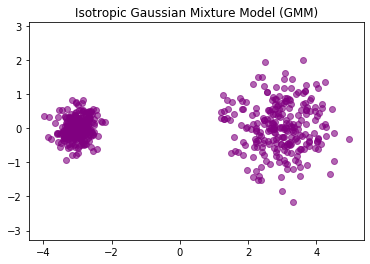

In [9]:
S = dist.get_samples(500)
fig = plt.figure()
plt.title('Isotropic Gaussian Mixture Model (GMM)')
# plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
plt.axis('equal')
plt.show()
# fig.savefig('iso_gmm_exact.png', dpi=200)

---
## Training

In [10]:
dynamics = Dynamics(x_dim, dist.get_energy_function(), T=10, eps=0.1, net_factory=network, use_temperature=True).to(device)

In [11]:
n_steps = 5000
n_samples = 200

In [12]:
optim = Adam(dynamics.parameters())
scheduler = StepLR(optim, step_size=1000, gamma=0.96)
scale = torch.tensor(0.1, device=device)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

# with torch.autograd.detect_anomaly():
for t in tqdm(range(n_steps)):
    tmp = 9.0 * (1 - t / float(n_steps)) + 1
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32, device=device)
    else:
        x = output[0].data #.to(device)

    z = torch.randn_like(x, device=device)

    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True, temperature=tmp)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False, temperature=tmp)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4, device=device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4, device=device)

    loss = criterion(v1, v2)
    
#     with torch.autograd.detect_anomaly():
#     set_trace()
    loss.backward()
    optim.step()
    
    if t % 100 == 0:
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<30:54,  2.70it/s]

Step: 0 / 5000, Loss: 3.33e+02, Acceptance sample: 0.18, LR: 0.00100


  2%|▏         | 101/5000 [00:38<30:59,  2.64it/s]

Step: 100 / 5000, Loss: -1.11e+01, Acceptance sample: 0.57, LR: 0.00100


  4%|▍         | 201/5000 [01:16<30:29,  2.62it/s]

Step: 200 / 5000, Loss: -1.35e+01, Acceptance sample: 0.54, LR: 0.00100


  6%|▌         | 301/5000 [01:54<31:03,  2.52it/s]

Step: 300 / 5000, Loss: -4.64e+01, Acceptance sample: 0.50, LR: 0.00100


  8%|▊         | 401/5000 [02:32<28:59,  2.64it/s]

Step: 400 / 5000, Loss: -1.32e+02, Acceptance sample: 0.37, LR: 0.00100


 10%|█         | 501/5000 [03:10<28:39,  2.62it/s]

Step: 500 / 5000, Loss: -2.60e+02, Acceptance sample: 0.41, LR: 0.00100


 12%|█▏        | 601/5000 [03:48<27:51,  2.63it/s]

Step: 600 / 5000, Loss: -4.82e+02, Acceptance sample: 0.71, LR: 0.00100


 14%|█▍        | 701/5000 [04:26<27:13,  2.63it/s]

Step: 700 / 5000, Loss: -5.29e+02, Acceptance sample: 0.77, LR: 0.00100


 16%|█▌        | 801/5000 [05:04<26:07,  2.68it/s]

Step: 800 / 5000, Loss: -6.30e+02, Acceptance sample: 0.81, LR: 0.00100


 18%|█▊        | 901/5000 [05:42<26:07,  2.61it/s]

Step: 900 / 5000, Loss: -6.28e+02, Acceptance sample: 0.81, LR: 0.00100


 20%|██        | 1001/5000 [06:21<25:09,  2.65it/s]

Step: 1000 / 5000, Loss: -6.03e+02, Acceptance sample: 0.85, LR: 0.00096


 22%|██▏       | 1101/5000 [06:58<24:23,  2.66it/s]

Step: 1100 / 5000, Loss: -5.75e+02, Acceptance sample: 0.79, LR: 0.00096


 24%|██▍       | 1201/5000 [07:36<24:27,  2.59it/s]

Step: 1200 / 5000, Loss: -6.30e+02, Acceptance sample: 0.84, LR: 0.00096


 26%|██▌       | 1301/5000 [08:14<23:23,  2.64it/s]

Step: 1300 / 5000, Loss: -5.91e+02, Acceptance sample: 0.82, LR: 0.00096


 28%|██▊       | 1401/5000 [08:53<22:46,  2.63it/s]

Step: 1400 / 5000, Loss: -6.05e+02, Acceptance sample: 0.81, LR: 0.00096


 30%|███       | 1501/5000 [09:31<22:09,  2.63it/s]

Step: 1500 / 5000, Loss: -6.59e+02, Acceptance sample: 0.80, LR: 0.00096


 32%|███▏      | 1601/5000 [10:09<22:16,  2.54it/s]

Step: 1600 / 5000, Loss: -5.97e+02, Acceptance sample: 0.79, LR: 0.00096


 34%|███▍      | 1701/5000 [10:47<20:45,  2.65it/s]

Step: 1700 / 5000, Loss: -6.36e+02, Acceptance sample: 0.83, LR: 0.00096


 36%|███▌      | 1801/5000 [11:25<20:09,  2.65it/s]

Step: 1800 / 5000, Loss: -5.41e+02, Acceptance sample: 0.79, LR: 0.00096


 38%|███▊      | 1901/5000 [12:03<19:26,  2.66it/s]

Step: 1900 / 5000, Loss: -6.00e+02, Acceptance sample: 0.80, LR: 0.00096


 40%|████      | 2001/5000 [12:41<19:09,  2.61it/s]

Step: 2000 / 5000, Loss: -5.82e+02, Acceptance sample: 0.82, LR: 0.00092


 42%|████▏     | 2101/5000 [13:19<18:27,  2.62it/s]

Step: 2100 / 5000, Loss: -5.85e+02, Acceptance sample: 0.76, LR: 0.00092


 44%|████▍     | 2201/5000 [13:58<17:31,  2.66it/s]

Step: 2200 / 5000, Loss: -6.03e+02, Acceptance sample: 0.79, LR: 0.00092


 46%|████▌     | 2301/5000 [14:36<16:55,  2.66it/s]

Step: 2300 / 5000, Loss: -5.92e+02, Acceptance sample: 0.79, LR: 0.00092


 48%|████▊     | 2401/5000 [15:14<16:26,  2.63it/s]

Step: 2400 / 5000, Loss: -5.92e+02, Acceptance sample: 0.82, LR: 0.00092


 50%|█████     | 2501/5000 [15:52<15:54,  2.62it/s]

Step: 2500 / 5000, Loss: -5.49e+02, Acceptance sample: 0.81, LR: 0.00092


 52%|█████▏    | 2601/5000 [16:29<14:59,  2.67it/s]

Step: 2600 / 5000, Loss: -5.27e+02, Acceptance sample: 0.77, LR: 0.00092


 54%|█████▍    | 2701/5000 [17:07<14:29,  2.64it/s]

Step: 2700 / 5000, Loss: -5.49e+02, Acceptance sample: 0.77, LR: 0.00092


 56%|█████▌    | 2801/5000 [17:45<13:49,  2.65it/s]

Step: 2800 / 5000, Loss: -5.53e+02, Acceptance sample: 0.78, LR: 0.00092


 58%|█████▊    | 2901/5000 [18:23<13:22,  2.62it/s]

Step: 2900 / 5000, Loss: -5.45e+02, Acceptance sample: 0.80, LR: 0.00092


 60%|██████    | 3001/5000 [19:01<12:43,  2.62it/s]

Step: 3000 / 5000, Loss: -4.67e+02, Acceptance sample: 0.72, LR: 0.00088


 62%|██████▏   | 3101/5000 [19:39<11:51,  2.67it/s]

Step: 3100 / 5000, Loss: -5.61e+02, Acceptance sample: 0.81, LR: 0.00088


 64%|██████▍   | 3201/5000 [20:17<11:28,  2.61it/s]

Step: 3200 / 5000, Loss: -5.46e+02, Acceptance sample: 0.76, LR: 0.00088


 66%|██████▌   | 3301/5000 [20:55<10:41,  2.65it/s]

Step: 3300 / 5000, Loss: -5.23e+02, Acceptance sample: 0.74, LR: 0.00088


 68%|██████▊   | 3401/5000 [21:33<09:50,  2.71it/s]

Step: 3400 / 5000, Loss: -5.48e+02, Acceptance sample: 0.80, LR: 0.00088


 70%|███████   | 3501/5000 [22:10<09:50,  2.54it/s]

Step: 3500 / 5000, Loss: -4.77e+02, Acceptance sample: 0.75, LR: 0.00088


 72%|███████▏  | 3601/5000 [22:48<08:47,  2.65it/s]

Step: 3600 / 5000, Loss: -5.19e+02, Acceptance sample: 0.75, LR: 0.00088


 74%|███████▍  | 3701/5000 [23:26<08:16,  2.62it/s]

Step: 3700 / 5000, Loss: -3.93e+02, Acceptance sample: 0.59, LR: 0.00088


 76%|███████▌  | 3801/5000 [24:04<07:31,  2.66it/s]

Step: 3800 / 5000, Loss: -4.92e+02, Acceptance sample: 0.79, LR: 0.00088


 78%|███████▊  | 3901/5000 [24:42<06:57,  2.63it/s]

Step: 3900 / 5000, Loss: -4.73e+02, Acceptance sample: 0.75, LR: 0.00088


 80%|████████  | 4001/5000 [25:20<06:14,  2.67it/s]

Step: 4000 / 5000, Loss: -5.07e+02, Acceptance sample: 0.75, LR: 0.00085


 82%|████████▏ | 4101/5000 [25:57<05:38,  2.66it/s]

Step: 4100 / 5000, Loss: -4.64e+02, Acceptance sample: 0.77, LR: 0.00085


 84%|████████▍ | 4201/5000 [26:35<04:57,  2.68it/s]

Step: 4200 / 5000, Loss: -4.91e+02, Acceptance sample: 0.72, LR: 0.00085


 86%|████████▌ | 4301/5000 [27:12<04:18,  2.70it/s]

Step: 4300 / 5000, Loss: -4.46e+02, Acceptance sample: 0.73, LR: 0.00085


 88%|████████▊ | 4401/5000 [27:49<03:48,  2.62it/s]

Step: 4400 / 5000, Loss: -4.74e+02, Acceptance sample: 0.77, LR: 0.00085


 90%|█████████ | 4501/5000 [28:27<03:04,  2.70it/s]

Step: 4500 / 5000, Loss: -4.66e+02, Acceptance sample: 0.72, LR: 0.00085


 92%|█████████▏| 4601/5000 [29:04<02:32,  2.62it/s]

Step: 4600 / 5000, Loss: -4.65e+02, Acceptance sample: 0.69, LR: 0.00085


 94%|█████████▍| 4701/5000 [29:42<01:53,  2.64it/s]

Step: 4700 / 5000, Loss: -4.19e+02, Acceptance sample: 0.69, LR: 0.00085


 96%|█████████▌| 4801/5000 [30:20<01:15,  2.65it/s]

Step: 4800 / 5000, Loss: -4.78e+02, Acceptance sample: 0.66, LR: 0.00085


 98%|█████████▊| 4901/5000 [30:58<00:37,  2.64it/s]

Step: 4900 / 5000, Loss: -3.14e+02, Acceptance sample: 0.42, LR: 0.00085


100%|██████████| 5000/5000 [31:36<00:00,  2.64it/s]


In [13]:
length_of_chains = 2000

In [14]:
samples = torch.tensor(dist.get_samples(n=n_samples), dtype=torch.float32, device=device)
final_samples = []

samples_ = samples
with torch.no_grad():
    for t in tqdm(range(length_of_chains)):
        final_samples.append(samples_.cpu().numpy())
        _, _, _, samples_ = propose(samples_, dynamics, do_mh_step=True, trainable=False)
        samples_ = samples_[0].detach()

100%|██████████| 2000/2000 [02:35<00:00, 13.04it/s]


In [15]:
L2HMC_samples = np.array(final_samples)
with torch.no_grad():
    HMC_samples_1 = get_hmc_samples(2, 0.1, dist.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_2 = get_hmc_samples(2, 0.15, dist.get_energy_function(), steps=length_of_chains, samples=samples)
    HMC_samples_3 = get_hmc_samples(2, 0.2, dist.get_energy_function(), steps=length_of_chains, samples=samples)

100%|██████████| 2000/2000 [00:52<00:00, 37.53it/s]


In [16]:
L2HMC_samples.shape

(2000, 200, 2)

In [17]:
HMC_samples_1.shape

(2000, 200, 2)

In [18]:
cov_= np.array([[4.1, 0], [0, 0.1]])
scale = np.sqrt(np.trace(cov_))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

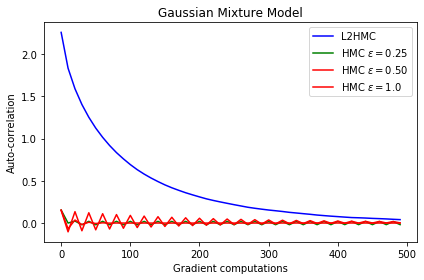

In [19]:
xaxis = 10 * np.arange(50)
fig = plt.figure()
plt.plot(xaxis, L2HMC[:50], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:50], label='HMC $\epsilon=0.25$', color=c_hmc2)
plt.plot(xaxis, HMC2[:50], label='HMC $\epsilon=0.50$', color=c_hmc3)
plt.plot(xaxis, HMC3[:50], label='HMC $\epsilon=1.0$', color=c_hmc3)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient computations')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('iso_gmm_plot.png', dpi=200)

In [20]:
# print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %.3f' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

### L2HMC samples overlayed on ground truth samples

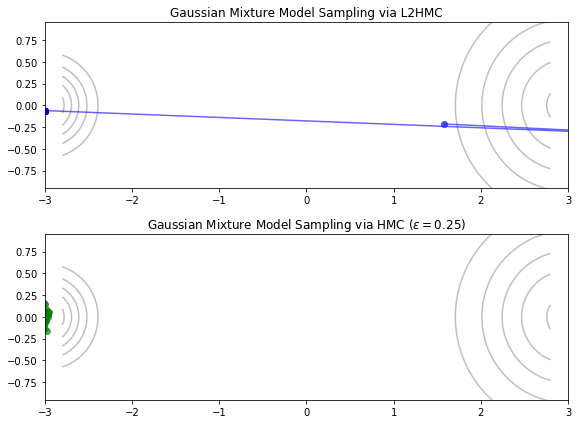

In [21]:
# plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=main)
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot(2,1,1)
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=200)
plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color=c_l2hmc, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via L2HMC')
plt.axis('equal')

ax2 = plt.subplot(2,1,2, sharex=ax1)
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=200)
plt.plot(HMC_samples_1[:50, 1, 0], HMC_samples_1[:50, 1, 1], color=c_hmc2, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.25$)')
plt.axis('equal')
plt.tight_layout()

plt.axis([-3,3,-2,2])

plt.show()
# fig.savefig('iso_gmm_explore.png', dpi=200)

### HMC samples (Leapfrog step: ε = 0.25)

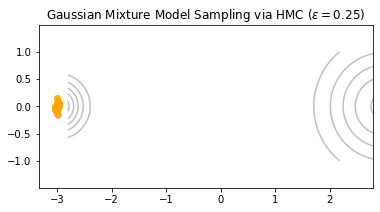

In [22]:
fig = plt.figure(figsize=(6, 3))
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1], res=100)
plt.plot(HMC_samples_1[:50, 1, 0], HMC_samples_1[:50, 1, 1], color=c_hmc1, marker='o', alpha=0.6)
plt.xlim([-5,5])
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.25$)')
plt.axis('equal')
plt.show()

### HMC samples (Leapfrog step: ε = 0.50)

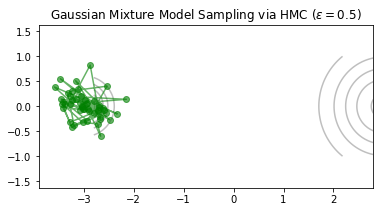

In [23]:
fig = plt.figure(figsize=(6, 3))
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-2.8,2.8], y_lims=[-1,1])
plt.plot(HMC_samples_2[:50, 1, 0], HMC_samples_2[:50, 1, 1], color=c_hmc2, marker='o', alpha=0.6)
plt.title('Gaussian Mixture Model Sampling via HMC ($\epsilon = 0.5$)')
plt.axis('equal')
plt.show()